## Dogs v Cats


In [159]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
import cv2

In [2]:
PATH = "ml_data/ablob/"
sz = 224
arch = resnet34
bs = 64

In [3]:
m = arch(True)

In [4]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [5]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [6]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [7]:
learn = ConvLearner.from_model_data(m, data)

In [8]:
learn.freeze_to(-4)

In [9]:
m[-1].trainable

True

In [10]:
m[-4].trainable

True

In [11]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.432016   0.0        1.0       



[array([ 0.]), 1.0]

In [12]:
learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.013345   0.0        1.0       



[array([ 0.]), 1.0]

In [13]:
learn.save("trained_model")

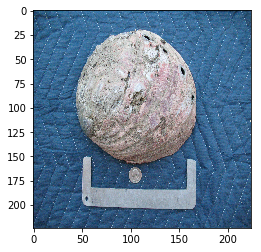

In [184]:
imgName = "GOPR1758.JPG"
targetPath = "data/ablob/test/lobster/"
imgName = "blue_abalone_rot.jpg"
targetPath = "data/ablob/test/abalone/"
#imgName="lobster.jpg"
#targetPath="data/ablob/test/"
targetImagePath = targetPath+imgName
targetImage = Image.open(targetImagePath).resize((224,224))
plt.imshow(targetImage)


In [185]:

ds = FilesIndexArrayDataset([imgName], np.array([0]), tfms[1], targetPath)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

0

## CAM

In [186]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [187]:
x,y = next(iter(dl))

In [188]:
x = x[None,0]
vx = Variable(x.cuda(), requires_grad=True)

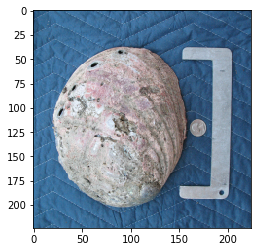

In [189]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [190]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [191]:
%time py = m(Variable(x.cuda()))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.47 ms


In [192]:
for o in sfs: o.remove()

In [193]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [194]:
py = np.exp(to_np(py)[0]); py

array([ 1.,  0.], dtype=float32)

In [195]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [196]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[ 0.06626,  0.15414,  0.21993,  0.22785,  0.18318,  0.10462,  0.02993],
       [ 0.18881,  0.37893,  0.51743,  0.53911,  0.43366,  0.25014,  0.08121],
       [ 0.31542,  0.60658,  0.81112,  0.85023,  0.68414,  0.38414,  0.11616],
       [ 0.39076,  0.73209,  0.95889,  1.     ,  0.79923,  0.44553,  0.12701],
       [ 0.39435,  0.73027,  0.94449,  0.96308,  0.74409,  0.39476,  0.09769],
       [ 0.30939,  0.57409,  0.73391,  0.72571,  0.5315 ,  0.26292,  0.05033],
       [ 0.15825,  0.30637,  0.38964,  0.37289,  0.25122,  0.10488,  0.     ]], dtype=float32)

In [197]:
dx

array([[[ 0.10987,  0.2205 ,  0.31498],
        [ 0.14183,  0.24557,  0.40442],
        [ 0.20891,  0.36467,  0.5405 ],
        ..., 
        [ 0.15415,  0.29052,  0.43284],
        [ 0.12424,  0.27102,  0.41538],
        [ 0.16681,  0.28205,  0.42558]],

       [[ 0.11472,  0.22213,  0.35738],
        [ 0.28417,  0.37825,  0.5119 ],
        [ 0.1936 ,  0.34995,  0.54735],
        ..., 
        [ 0.17412,  0.30693,  0.47795],
        [ 0.15426,  0.27731,  0.42761],
        [ 0.14677,  0.26181,  0.41091]],

       [[ 0.1092 ,  0.23108,  0.33637],
        [ 0.13567,  0.2793 ,  0.44325],
        [ 0.18046,  0.36695,  0.53982],
        ..., 
        [ 0.18277,  0.34356,  0.48933],
        [ 0.15118,  0.29769,  0.4496 ],
        [ 0.13421,  0.27261,  0.40951]],

       ..., 
       [[ 0.1751 ,  0.41829,  0.59303],
        [ 0.1931 ,  0.43292,  0.62691],
        [ 0.2158 ,  0.44367,  0.6114 ],
        ..., 
        [ 0.18113,  0.32058,  0.45975],
        [ 0.15749,  0.31003,  0.46679],
     

In [198]:
f2F = np.ma.masked_where(f2 <= 0.7, f2)
f2F

masked_array(data =
 [[-- -- -- -- -- -- --]
 [-- -- -- -- -- -- --]
 [-- -- 0.811119556427002 0.8502267003059387 -- -- --]
 [-- 0.7320875525474548 0.9588901996612549 1.0 0.7992347478866577 -- --]
 [-- 0.730273425579071 0.9444851875305176 0.9630768299102783 0.7440943121910095 -- --]
 [-- -- 0.7339141368865967 0.7257117629051208 -- -- --]
 [-- -- -- -- -- -- --]],
             mask =
 [[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True False False  True  True  True]
 [ True False False False False  True  True]
 [ True False False False False  True  True]
 [ True  True False False  True  True  True]
 [ True  True  True  True  True  True  True]],
       fill_value = 1e+20)

In [199]:
filter = scipy.misc.imresize(f2F, dx.shape,mode="L")
filter

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


array([[17, 17, 17, ...,  8,  8,  8],
       [17, 17, 17, ...,  8,  8,  8],
       [17, 17, 17, ...,  8,  8,  8],
       ..., 
       [40, 40, 40, ...,  0,  0,  0],
       [40, 40, 40, ...,  0,  0,  0],
       [40, 40, 40, ...,  0,  0,  0]], dtype=uint8)

In [204]:
f2Filtered = np.ma.masked_where(filter <= 140, filter)


In [205]:
minX = 1000
minY = 1000
maxX = 0
maxY = 0

for i in range(0,len(f2Filtered)):
    for j in range(0,len(f2Filtered[0])):
        val = f2Filtered[i][j]
        if val > 0:
            if i < minX:
                minX = i
            if j < minY:
                minY = j
            if i > maxX:
                maxX = i
            if j > maxY:
                maxY = j
xrange = (minX, maxX)
yrange = (minX, maxY)
print("x range: ", xrange)
print("y range: ", yrange)

x range:  (49, 192)
y range:  (49, 166)


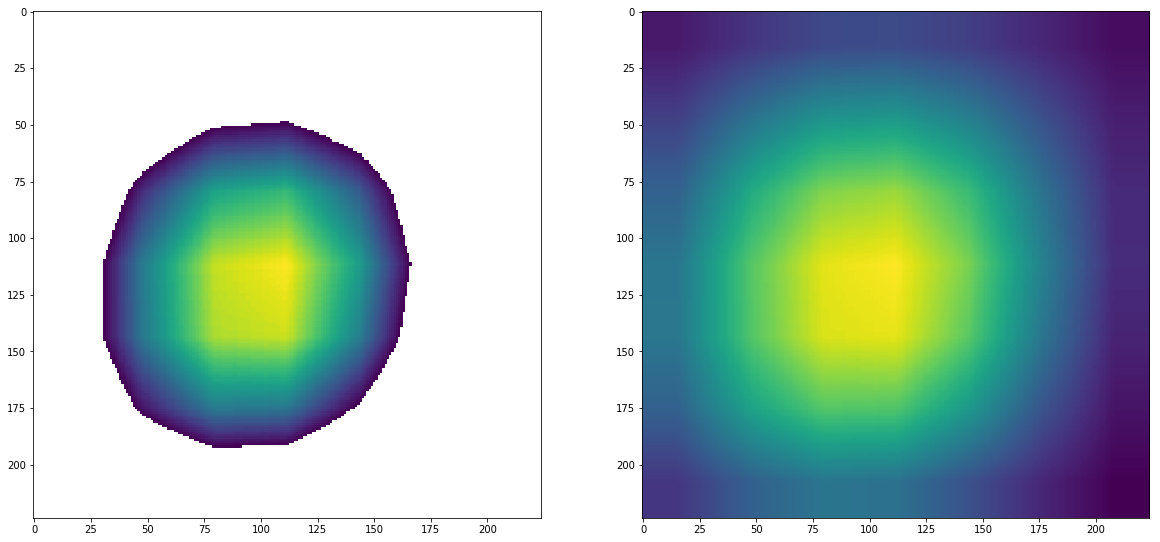

In [206]:
fig=plt.figure(figsize=(20, 20))
fig.add_subplot(1,2, 1)
plt.imshow(f2Filtered)
fig.add_subplot(1,2,2)
plt.imshow(filter)
plt.show()

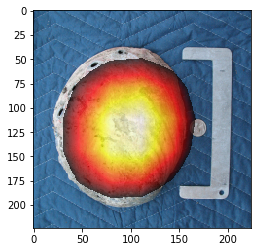

In [207]:
plt.imshow(dx)
plt.imshow(f2Filtered, alpha=0.7, cmap='hot');

## Model

In [153]:
learn.unfreeze()
learn.bn_freeze(True)

In [154]:
lr=np.array([1e-6,1e-4,1e-2])

In [155]:
learn.fit(lr, 2, cycle_len=1)

AssertionError: 

In [156]:
accuracy_np(*learn.TTA())

AttributeError: 'bool' object has no attribute 'mean'

In [ ]:
learn.fit(lr, 2, cycle_len=1)

In [43]:
accuracy_np(*learn.TTA())

0.99650000000000005